In [556]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import multinomial, multivariate_normal

# Introductiion
This notebook contains code for a gaussian markov model

# Data Generation
To test the model, I create a toy dataset consisting of datapoints drawn from 2 gaussians.

<AxesSubplot:>

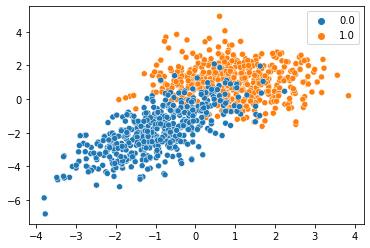

In [568]:
# First Gaussian
mu_1 = [1,1]
sigma_1 = np.asarray([[1,0],[0,1]])
x_1 = np.random.multivariate_normal(mu_1, sigma_1, 500)
y_1 = np.ones_like(x_1[:,1])

# Second Gaussian
mu_2 = [-1,-2]
sigma_2 = np.asarray([[1,1],[1,2]])
x_2 = np.random.multivariate_normal(mu_2, sigma_2, 500)
y_2 = np.zeros_like(x_2[:,1])

x = np.vstack([x_1, x_2])
y = np.hstack([y_1, y_2])

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

## Initialization Code
This code is probably unnecessary. It draws latent variables from a multinomial distribution, then uses those latent variables to calculate the first set of parameters for the normal and multinomial distributions.

In [571]:
def init_z(n, k):
    '''
    Initializes distributions for first E-step. z are drawn from multinomial with equal probability of each event.
    n samples
    k classes
    '''
    p_vals = [1/k for i in range(k-1)]
    p_vals.append(1-np.sum(p_vals))
    z = np.random.multinomial(n=1, pvals=[1/k]*k, size=n)
    z = np.argmax(z, axis=1)
    return z

def make_identity_array(z, j, data_dim):
    '''
    Useful for computing identity function. For array 0, return array taking value 1 if z_i == j, 0 otherwise
    '''
    identity_array = np.where(z == j, 1, 0)
    identity_array = np.stack([identity_array for i in range(data_dim)], axis=-1)
    return identity_array

def e_step_phi(identity_array):
    M = identity_array.shape[0]
    phi = (1/M)*np.sum(identity_array[:,0])
    return phi

def e_step_mu(x, identity_array):
    # Sum terms where the identify function is 1  
    mu = np.where(identity_array==1, x, 0)
    mu = np.sum(mu)
    mu /= np.sum(identity_array, axis=0)
    return mu

def e_step_sigma(x, identity_array):
    # Sum terms where the identify function is 1
    sigma = np.where(identity_array==1, x, 0)
    sigma -= x
    data_dim = x.shape[-1]
    sigma = sigma.reshape(-1, 1, data_dim) # (num_samples, 1,  data_dim)
    sigma = np.multiply(sigma.reshape(-1, 2, 1), sigma) # (num_samples, data_dim, data_dim)
    sigma = np.sum(sigma, axis=0)
    sigma /= np.sum(identity_array) # (data_dim, data_dim)
    return sigma

def init_params(x, k): # for data x and k gaussians
    num_samples = x.shape[0]
    data_dim = x.shape[-1]
    
    z = init_z(num_samples, k)
    phis = np.zeros(k)
    sigmas = np.zeros((k, data_dim, data_dim))
    mus = np.zeros((k, 1, data_dim))
    
    for i in range(k):
        identity_array = make_identity_array(z, i, data_dim)
        phis[i] = e_step_phi(identity_array)
        sigmas[i] = e_step_sigma(x, identity_array)
        mus[i] = e_step_mu(x, identity_array)
        
    return phis, sigmas, np.squeeze(mus)

phis, sigmas, mus = init_params(x, 2)
sigmas, mus

(array([[[0.93801074, 0.89843959],
         [0.89843959, 1.75475088]],
 
        [[0.94377869, 0.94841254],
         [0.94841254, 2.0427982 ]]]),
 array([[-0.51399604, -0.51399604],
        [-0.28451432, -0.28451432]]))

# E-Step Code

Code to compute $w^{(i)}_j$ for some known $\phi, \Sigma, \mu$. The variable $w^{(i)}_j$ gives the probability that datapoint i belongs to Gaussian j.

In [626]:
def multinomial_pdf(phis, j):
    '''
    Assuming 1 trial
    '''
    return phis[j]

def gaussian_pdf(x, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(x)

def e_step(x, mus, sigmas, phis, k):
    data_dim = x.shape[0]
    probs = np.zeros((data_dim, k))
    for i, mu in enumerate(mus):
        prob_x_given_z = gaussian_pdf(x, mu, sigmas[i])
        prob_z = multinomial_pdf(phis, i)
        probs[:, i] = prob_x_given_z * prob_z
        
    # Normalize
    denominator = np.sum(probs, axis=1)
    denominator = np.stack([denominator for j in range(k)], axis=1)
    
    w = probs /denominator
    
    return w
    
phis, sigmas, mus = init_params(x, 2)
w = e_step(x, mus, sigmas, phis, 2)

# M-step
This recomputes new parameters for each distribution using the variable $w$.

In [561]:
def m_step_phi(w):
    print
    phi = np.sum(w, axis=0)
    phi /= w.shape[0]
    return phi

def m_step_mu(x, w, phis):
    n_samples = x.shape[0]
    data_dim = x.shape[1]
    k = w.shape[1]
    mu = np.zeros((k, data_dim))
    for j in range(k):
        mu_j = np.stack([w[:, j], w[:, j]], axis=-1)*x
        mu_j = np.sum(mu_j, axis=0)
        denominator = phis[j]*n_samples
        mu_j /= denominator
        mu[j] = mu_j
    return mu

def m_step_sigma(x, w, phi, mu):
    n_samples = x.shape[0]
    data_dim = x.shape[1]
    k  = w.shape[1]
    sigma = np.zeros((k, data_dim, data_dim))
    
    for j in range(k):
        diff = x - mu[j]
        w_vec = np.stack([w[:, j], w[:, j]], axis=-1)
        diff_mult = diff*w_vec
        
        diff_mult = diff_mult[:, np.newaxis, :]
        diff = diff[:, :, np.newaxis]
        numerator = diff*diff_mult
        
        denominator = phi[j]*n_samples
        sigma_j = np.sum(numerator, axis=0)
        sigma_j /= denominator
        
        sigma[j] = sigma_j
        
    return sigma
        

def m_step(x, w, phis, mus):
    phis = m_step_phi(w)
    mus = m_step_mu(x, w, phis)
    sigma = m_step_sigma(x, w, phis, mus)
    
    return mus, phis, sigmas

# Combine E-Step and M-Step
The Gaussian mixture model is trained by performing the E-step and M-step iteratively until some convergence condition is met.

Finished in 119 iterations


<AxesSubplot:>

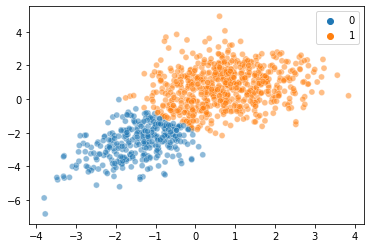

In [629]:
def GMM(x, k):
    phis, sigmas, mus = init_params(x, k)
    w_old = e_step(x, mus, sigmas, phis, k)
    shift = 10
    i = 1
    
    while shift > 1e-10:
        mus, phis, sigmas = m_step(x, w_old, phis, mus)
        w_new = e_step(x, mus, sigmas, phis, k)
        shift = np.linalg.norm(w_new-w_old)
        w_old = w_new.copy()
        i += 1
        
    print(f'Finished in {i} iterations')
    return w_new, mus, phis, sigmas

w, mus, phis, sigmas = GMM(x, 2)
y_hat = np.argmax(w, axis=1)

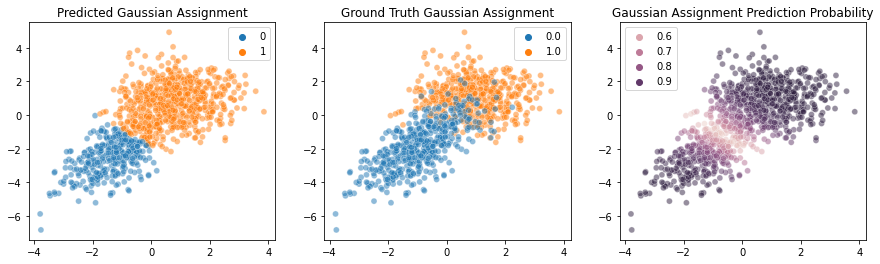

In [647]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
y_hat = np.argmax(w, axis=1)
y_probs = np.max(w, axis=1)

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y_hat, alpha=0.5, ax=axes[0])
axes[0].set_title('Predicted Gaussian Assignment')

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, alpha=0.5, ax=axes[1])
axes[1].set_title('Ground Truth Gaussian Assignment')

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y_probs, alpha=0.5, ax=axes[2])
axes[2].set_title('Gaussian Assignment Prediction Probability')

plt.show()

We can see from the above that prediction probabilities are low around what looks like a line between the two means. However, the prediction probabilities are still high when incorrect in areas of overlap.

# Computing P(x)
One of the benefits of the GMM is that it can easily be used to compute P(x).

In [ ]:
def multinomial_pdf(phis, j):
    '''
    Assuming 1 trial
    '''
    return phis[j]

def gaussian_pdf(x, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(x)

In [660]:
def compute_prob_density(mus, phis, sigmas):
    k = len(phis)
    probs = np.zeros((k, x.shape[0]))
    for i, phi in enumerate(phis):
        prob_x_given_z = gaussian_pdf(x, mus[i], sigmas[i])
        prob_z = phi
        probs[i] = prob_x_given_z * prob_z
        
    probs = np.sum(probs, axis=0)
    
    return probs
    
p_x = compute_prob_density(mus, phis, sigmas)

array([1.02389969e-01, 3.27682825e-02, 5.90674644e-02, 7.44614750e-02,
       3.85587827e-02, 1.21872350e-02, 7.58284522e-02, 9.22757999e-03,
       5.41107389e-02, 8.91887891e-02, 4.55879950e-02, 1.01913305e-01,
       3.97747733e-02, 5.93450913e-02, 5.27761291e-02, 4.12615556e-04,
       8.89240030e-02, 7.73403245e-02, 1.32562358e-02, 1.06650428e-01,
       1.27615966e-06, 1.15376121e-02, 9.30531552e-02, 2.19972694e-02,
       4.74793054e-02, 1.50680577e-02, 6.07557459e-02, 4.37862442e-02,
       1.24018731e-02, 8.75389171e-02, 2.87435865e-06, 7.44997897e-02,
       1.11989204e-02, 8.86431584e-02, 1.25871999e-02, 3.51989969e-02,
       8.45428741e-02, 5.72068753e-02, 2.48057286e-02, 2.89575827e-02,
       6.45096647e-02, 1.44957666e-02, 2.58622920e-02, 1.01168415e-01,
       6.80932059e-03, 6.10533265e-02, 6.62542127e-02, 1.20930546e-03,
       1.20050766e-02, 2.11700359e-03, 9.56720752e-04, 4.80320989e-02,
       8.63453876e-02, 5.68620880e-02, 6.45252028e-02, 1.00573972e-01,
      